# **Insert Title Here**
**DATA103 S11 Group 4**
- GOZON, Jean Pauline D.
- JAMIAS, Gillian Nicole A.
- MARCELO Andrea Jean C. 
- REYES, Anton Gabriel G.
- VICENTE, Francheska Josefa

## **Introduction**

Social media recommendation algorithms are steadily improving—they are nowadays more likely to show content that users will interact with. This is by recommending contents based on the previous interactions of users. However, a disadvantage of this is, what would be the resulting recommendations to a person who is depressed that mostly interacts with depressing content? In the scenario that it would recommend triggering content, what could prevent these recommendations?

Every individual’s life is immeasurable in terms of worth. Depression and suicide are topics that should be taken seriously. More often than not, people focus on the physical being instead of the mental being. For some people, going to professionals and even guidance counselors for mental health concerns are considered taboo or looked down upon. Thus, people may result in posting their thoughts anonymously online as a means to cope with negative thoughts. 

The use of social media in this case, Reddit, is part of an individual’s online self-presentation and may paint a bigger picture that cannot be found in a face-to-face setting. After a successful model has been created with the capability to classify text whether it is related to suicide or depression in nature, this study is a supplement to the prevention of suicide and may provide assistance to mental health concerns like depression. 

Those individuals that fall into the generated classes can be presented with appropriate suicide prevention Web pages or mental health resources. Additionally, social media algorithms could be prevented in suggesting triggering content to these people. For future studies, suicide prevention and mental health assistance can be improved through the implementation of the results of this project.

## **Requirements and Imports**

### Imports

**Basic Libraries**

* `numpy` contains a large collection of mathematical functions
* `pandas` contains functions that are designed for data manipulation and data analysis

In [2]:
import numpy as np
import pandas as pd
import datasets

**Visualization Libraries**

* `matplotlib.pyplot` contains functions to create interactive plots
* `seaborn` is a library based on matplotlib that allows for data visualization
* `spacy` is a Python-based open-source library used in processing text data. 
* `wordcloud` contains functions for generating wordclouds from text data 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import WordCloud, STOPWORDS

**Natural Language Processing Libraries**
* `re` is a module that allows the use of regular expressions
* `nltk` provides functions for processing text data
* `stopwords` is a corpus from NLTK, which includes a compiled list of stopwords
* `Counter` is from Python's collections module, which is helpful for tokenization
* `string` contains functions for string operations
* `TFidfVectorizer` converts the given text documents into a matrix, which has TF-IDF features
* `CountVectorizer` converts the given text documents into a matrix, which has the counts of the tokens

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk import ngrams

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
from collections import Counter
import string

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

**Machine Learning Libraries**

* `torch` this is an open source ML library for deep neural network creation
* `transformers` contains pre-trained models


In [8]:
#!pip install transformers

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_lightning.callbacks import ProgressBarBase, RichProgressBar

ImportError: cannot import name 'ProgressBarBase' from 'pytorch_lightning.callbacks' (c:\Users\user\anaconda3\envs\data103\lib\site-packages\pytorch_lightning\callbacks\__init__.py)

In [11]:
from transformers import AutoTokenizer, BertTokenizerFast, AutoModelForSequenceClassification, TrainerCallback, TrainingArguments, Trainer

In [12]:
from sklearn.metrics import f1_score, roc_auc_score, hamming_loss, accuracy_score
from transformers import EvalPrediction
import evaluate

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [14]:
import pickle

**Google Drive**
* `google.colab` a library that allows the colab notebook to mount the google drive

#### Datasets and Files

The following `.csv` files were used in this project:
* `Suicide_Detection.csv` contains the text itself and the two classes namely suicide and non-suicide. Retrieved from the "Suicide and Depression Detection" in Kaggle
* `twitter-suicidal-intention-dataset.csv` similar to `Suicide_Detection.csv` but intention is numbered. For the intention column, 1 means tweet is suicidal and 0 means it is not. Retrieved from github.
* `500_anonymized_Reddit_users_posts_labels.csv` contains text from a post and the label of intention. (4 labels available)
* `suicide notes.csv` contains text of suicide notes but it does not have a column labelling the notes as suicidal

## **Data Collection**

By importing the different `.csv` files into the notebook using the [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function, the [`head`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) function is called to check the first few rows of the dataset. This will let have a glance on the features of the dataset.

In [15]:
#importing the .csv file from kaggle
watch_df = pd.read_csv('data/Suicide_Detection.csv')
watch_df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [16]:
# importing the twitter dataset
url = "https://raw.githubusercontent.com/laxmimerit/twitter-suicidal-intention-dataset/master/twitter-suicidal_data.csv"
twit_df = pd.read_csv(url)
twit_df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [17]:
notes_df = pd.read_csv("data/suicide notes.csv")
notes_df.head()

,id,text
0,1,I have to put this in writing somehow so I sti...
1,2,I've made my peace with the fact that I'm goin...
2,3,I really want help now i just cant so this any...
3,4,I can't think of any reason to stay. I have no...
4,5,NaN


In [18]:
anon_df = pd.read_csv("data/500_anonymized_Reddit_posts.csv")
anon_df.head()

,User,Post,Label
0,user-0,"['Its not a viable option, and youll be leavin...",Supportive
1,user-1,['It can be hard to appreciate the notion that...,Ideation
2,user-2,"['Hi, so last night i was sitting on the ledge...",Behavior
3,user-3,['I tried to kill my self once and failed badl...,Attempt
4,user-4,['Hi NEM3030. What sorts of things do you enjo...,Ideation


To check all the individual classes, the [`unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) function was called to see all distinct values. The notes.df does not have any additional column aside from text so there are no unique values to be checked.

In [19]:
print(watch_df["class"].unique())
print(twit_df["intention"].unique())
print(anon_df["Label"].unique())

['suicide' 'non-suicide']
[1 0]
['Supportive' 'Ideation' 'Behavior' 'Attempt' 'Indicator']


## **Description of the Dataset**

Using the [`shape`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html) function, the number of rows and columns can be obtained for all dataframes collected. The `watch_df`  has 232074 rows (instances) and three (3) columns (features). The `twit_df` has 9119 rows (instances) and two (2) columns (features) The `anon_df` has 500 rows (instances) and three (3) columns (features). The `notes_df` has 498 rows (instances) and two (2) columns (features). An instance in our dataset represents a text and its categories (labels).

In [20]:
#getting the shape of the four datasets
display(watch_df.shape, twit_df.shape, anon_df.shape, notes_df.shape)

(232074, 3)

(9119, 2)

(500, 3)

(498, 2)

The [`info`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) function provides information about a DataFrame including the index data type and columns, non-null values, and memory usage. The main reason for running this function is to see the data types of all the columns in each Dataframe.

In [21]:
print(watch_df.info(), twit_df.info(), anon_df.info(), notes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   User    500 non-null    object
 1   Post    500 non-null    object
 2   Label   500 non-null    object
dtypes: object(3)
memory usage: 11.8+

After seeing the number of features in each column per dataset, dataframes `watch_df`, `twit_df`, and `anon_df` are complete. However, dataframe `notes_df` contains null values. 

## **Data Preprocessing**

For data pre-processing, we checked if the four dataframes we collected: (1) has NaN values, (2) has data type uniformity in a class column such as non-suicidial text set to a value of zero and suicidual text set to a value of one. The four dataframes respective text and class columns were merged into one dataframe to be used in different models.

### DataFrames

Since the dataframe `notes_df` has null values, we will get rid of those rows using panda's [`dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html?highlight=dropna#pandas.DataFrame.dropna) function. Setting the axis to 0 allows us to drop rows which contain missing values. Additionally, the how parameter set to any causes that row to be removed if there is at least 1 null value present in that row. Having inplace equal to true modifies the exisiting Dataframe.

In [22]:
notes_df.dropna(axis = 0, how = "any", inplace=True)

After checking the total number of null values  in the whole `notes_df` we can see it is equal to zero.

In [23]:
notes_df.isnull().sum().sum()

0

For some of the dataframes, the `user`, `id`, and `unnamed column` would not be needed and therefore would be dropped.

In [24]:
anon_df = anon_df.drop("User", axis = 1)
notes_df = notes_df.drop("id", axis = 1)
watch_df = watch_df.drop("Unnamed: 0", axis = 1)

In [25]:
display("anon_df",anon_df.columns, "notes_df", notes_df.columns, "watch_df", watch_df.columns)

'anon_df'

Index(['Post', 'Label'], dtype='object')

'notes_df'

Index(['text'], dtype='object')

'watch_df'

Index(['text', 'class'], dtype='object')

In [26]:
display("anon_df",anon_df.head(), 
        "notes_df", notes_df.head(), 
        "twit_df", twit_df.head(), 
        "watch_df", watch_df.head())

'anon_df'

,Post,Label
0,"['Its not a viable option, and youll be leavin...",Supportive
1,['It can be hard to appreciate the notion that...,Ideation
2,"['Hi, so last night i was sitting on the ledge...",Behavior
3,['I tried to kill my self once and failed badl...,Attempt
4,['Hi NEM3030. What sorts of things do you enjo...,Ideation


'notes_df'

,text
0,I have to put this in writing somehow so I sti...
1,I've made my peace with the fact that I'm goin...
2,I really want help now i just cant so this any...
3,I can't think of any reason to stay. I have no...
5,"Hi, it's my first post here, I'm new in this c..."


'twit_df'

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


'watch_df'

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


After dropping the unecessary columns, it was then time to convert the values for the labeling columns so that once the dataframes are joined, there wouldn't be any further complications. 

Reviewing the columns of all the datasets we imported

In [27]:
display("anon_df columns", list(anon_df.columns),"notes_df columns", list(notes_df.columns),
        "twit_df columns", list(twit_df.columns), "watch_df columns", list(watch_df.columns))

'anon_df columns'

['Post', 'Label']

'notes_df columns'

['text']

'twit_df columns'

['tweet', 'intention']

'watch_df columns'

['text', 'class']

Creating a copy of `watch_df` before modifying the values to match `twit_df` (1 means text is suicidal and 0 means it is not) through the [`copy`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html) function.

In [28]:
integerwatch_df = watch_df.copy(deep=True)

Using pandas [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html?highlight=replace#pandas.DataFrame.replace) function to change multiple values with multiple new values for an individual DataFrame column

In [29]:
integerwatch_df['class'] = integerwatch_df['class'].replace(['suicide', 'non-suicide'], ['1', '0'])

In [30]:
integerwatch_df.head() #checking if the replace function reflected

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


Using [`info`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) to check the datatypes of the dataframe `intgerwatch_df`

In [31]:
integerwatch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


Using pandas [`astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html?highlight=astype#pandas.DataFrame.astype) function allows us to convert the obj data type in the class column to integer for uniformity with other dataframes

In [32]:
integerwatch_df['class'] = integerwatch_df['class'].astype('int')

Creating a copy of `notes_df` before modifying the values to match twit_df (1 means text is suicidal and 0 means it is not) through the [`copy`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html) function

In [33]:
integerwatch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 2.7+ MB


In [34]:
integernotes_df = notes_df.copy(deep=True)

Creating a new column named class and setting it to have a constant value of 1 since all texts are posted by users with  suicidal thoughts

In [35]:
integernotes_df['class'] = 1

In [36]:
integernotes_df.head() #checking if the new class column was addded

,text,class
0,I have to put this in writing somehow so I sti...,1
1,I've made my peace with the fact that I'm goin...,1
2,I really want help now i just cant so this any...,1
3,I can't think of any reason to stay. I have no...,1
5,"Hi, it's my first post here, I'm new in this c...",1


Creating a copy of `twit_df` before modifying the column names to match `integerwatch_df` and `integernotes_df`

In [37]:
new_twit = twit_df.copy(deep=True)

To match `new_twit` to the other Dataframes, renaming was done using pandas [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html?highlight=rename#pandas.DataFrame.rename) function. It uses a dictionary of new and old column names. Inplace set to true modified the existing Dataframe.

In [38]:
new_twit.rename(columns={"tweet": "text", "intention": "class"}, inplace=True)

In [39]:
new_twit.head() #checking if column names are renamed

,text,class
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


For `anon_df`, there are five unique values with their respective counts:

In [40]:
anon_df.Label.value_counts()

Ideation      171
Supportive    108
Indicator      99
Behavior       77
Attempt        45
Name: Label, dtype: int64

Columns for `anon_df` were renamed for consistency with the other dataframes.

In [41]:
anon_df.rename(columns={"Post": "text", "Label": "class"}, inplace=True)

Copying `anon_df` before modifying other values.

In [42]:
intanon_df = anon_df.copy(deep =  True)

Using pandas [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html?highlight=replace#pandas.DataFrame.replace)  function to change multiple values with multiple new values for an individual DataFrame column. For `intanon_df` the 5 values were replaced with a corrosponding `1` or `0` value.

In [43]:
intanon_df['class'] = intanon_df['class'].replace(['Ideation', 'Indicator','Behavior','Attempt','Supportive'], ['1','1','1','1','0'])

Using the [`astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html?highlight=astype#pandas.DataFrame.astype) function to convert the `class` value's types into `int` or an `integer` type. 

In [44]:
intanon_df['class'] = intanon_df['class'].astype('int')

Looking at the tail of `intanon_df` to check if the `class` values were replaced and converted accordingly. 

In [45]:
intanon_df.tail()

,text,class
495,"['Its not the end, it just feels that way. Or ...",0
496,"['It was a skype call, but she ended it and Ve...",1
497,['That sounds really weird.Maybe you were Dist...,0
498,['Dont know there as dumb as it sounds I feel ...,1
499,"['&gt;It gets better, trust me.Ive spent long ...",1


After changing column names for `anon_df` the following values were changed:

* Ideation = 1
* Indicatior = 1
* Behavior = 1
* Attempt = 1
* Supportive = 0

#### All dataframes

Displaying the dataframes we have now

In [46]:
display("intanon_df",intanon_df.head(), 
        "integernotes_df", integernotes_df.head(), 
        "new_twit", new_twit.head(), 
        "integerwatch_df", integerwatch_df.head())

'intanon_df'

,text,class
0,"['Its not a viable option, and youll be leavin...",0
1,['It can be hard to appreciate the notion that...,1
2,"['Hi, so last night i was sitting on the ledge...",1
3,['I tried to kill my self once and failed badl...,1
4,['Hi NEM3030. What sorts of things do you enjo...,1


'integernotes_df'

,text,class
0,I have to put this in writing somehow so I sti...,1
1,I've made my peace with the fact that I'm goin...,1
2,I really want help now i just cant so this any...,1
3,I can't think of any reason to stay. I have no...,1
5,"Hi, it's my first post here, I'm new in this c...",1


'new_twit'

,text,class
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


'integerwatch_df'

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


We switch the placement of the `text` and `class` columns in all four dataframes.

In [47]:
new_column_order = ['class', 'text'] #making the new column order

intanon_df = intanon_df[new_column_order]
integernotes_df = integernotes_df[new_column_order]
new_twit = new_twit[new_column_order]
integerwatch_df = integerwatch_df[new_column_order]

Using the [`concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html?highlight=concat#pandas.concat) function, we merge all the dataframes into one dataframe named `main_df`.

In [48]:
main_df = pd.concat([intanon_df, integernotes_df, new_twit, integerwatch_df], axis=0)

We now check if the merged dataframe for its shape.

In [49]:
display(main_df.shape , main_df["class"].unique())

(242160, 2)

array([0, 1], dtype=int64)

Duplicate rows in the `main_df` were checked using the [`duplicated`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) function. 

In [50]:
main_df [main_df.duplicated()]

,class,text
224,1,I attempted suicide and now stuck on bed cause...
242,1,I’ve been thinking abt it and if/when I do com...
3924,0,
4047,0,homework
4304,0,
...,...,...
8974,0,
9003,0,i am here for you
9010,0,i am here for you
9038,0,


## **Data Cleaning**

The group cleaned the data by removing text that we deemed inconsequential such as retweet labels, usernames, media links, square brackets, and hashtags. Moreover, whitespace was removed to easily identify cases of duplicates in the text column. 

### Removing unnecessary character sequences

We created a RegEx function to remove unnecessary character sequences that might potentially interfere with the next steps before modeling.

In [51]:
def remove_unnecessary(text):
    text = re.sub('RT', '', text) #RT
    text = re.sub('@[^\s]+', '', text) #usernames
    text = re.sub('http[^\s]+','',text) #media links
    text = re.sub(r'\[|\]', '', text) #square brackets
    text = re.sub('#[^ ]+', '', text) #hashtags
    return text

But before applying the function, a copy of the `concat` dataframe was created.

In [52]:
master = main_df.copy(deep = True)

Here, the function was applied to the `master` dataframe.

In [53]:
master['text'] = master['text'].apply(remove_unnecessary)

Checking if the `remove_unnecessary` function was applied.

In [54]:
master.head()

,class,text
0,0,"'Its not a viable option, and youll be leaving..."
1,1,'It can be hard to appreciate the notion that ...
2,1,"'Hi, so last night i was sitting on the ledge ..."
3,1,'I tried to kill my self once and failed badly...
4,1,'Hi NEM3030. What sorts of things do you enjoy...


The [`strip`](https://www.w3schools.com/python/ref_string_strip.asp) function is used to trim a string and remove any whitespace, whether leading or trailing. The apply and lambda function allows us to perform it to each element of the column named "text".

In [55]:
master['text'] = master['text'].apply(lambda x: x.strip())

Duplicate rows in the `master` dataframe were checked using the [`duplicated`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) function. As certain rows may act as a bias in the model.

In [56]:
master [master.duplicated()]

,class,text
224,1,I attempted suicide and now stuck on bed cause...
242,1,I’ve been thinking abt it and if/when I do com...
3924,0,
4047,0,homework
4224,0,oh no
...,...,...
218415,0,I'm currently in AP Research and my project is...
222846,0,Happy birthday Happy birthday to anyone who h...
223415,0,Java 1.16.4 Survival Players welcomed! **IP: p...
223851,0,


Checking the shape of the `master` dataframe.

In [56]:
master.shape

(242160, 2)

Checking if there are any null values in the `master` dataframe.

In [57]:
master.isnull().sum().sum()

0

In [58]:
master [master.duplicated()]

,class,text
224,1,I attempted suicide and now stuck on bed cause...
242,1,I’ve been thinking abt it and if/when I do com...
3924,0,
4047,0,homework
4224,0,oh no
...,...,...
218415,0,I'm currently in AP Research and my project is...
222846,0,Happy birthday Happy birthday to anyone who h...
223415,0,Java 1.16.4 Survival Players welcomed! **IP: p...
223851,0,


### **Converting the text in the `text` column for `main_df`**

Because we will be using `bert-base-uncased`, we will be needing the text data itself to be all lowercase.

First, we check the dataframe before we convert the text.

In [59]:
main_df.head()

,class,text
0,0,"['Its not a viable option, and youll be leavin..."
1,1,['It can be hard to appreciate the notion that...
2,1,"['Hi, so last night i was sitting on the ledge..."
3,1,['I tried to kill my self once and failed badl...
4,1,['Hi NEM3030. What sorts of things do you enjo...


We now use the [`.str.lower()`](https://www.geeksforgeeks.org/python-pandas-series-str-lower-upper-and-title/?ref=rp) function to put all the text in the `text` column to lowercase. After that, we check if the function was applied.

In [60]:
# main_df['text'] = main_df['text'].str.lower()

#master['text'] = master['text'].str.lower()
#un-comment the line above if the other dataframe needs to be lowercase as well.

In [61]:
main_df.head()

,class,text
0,0,"['Its not a viable option, and youll be leavin..."
1,1,['It can be hard to appreciate the notion that...
2,1,"['Hi, so last night i was sitting on the ledge..."
3,1,['I tried to kill my self once and failed badl...
4,1,['Hi NEM3030. What sorts of things do you enjo...


Checking if there are any null values in the `master` dataframe.

In [62]:
main_df.isnull().sum().sum()

0

### **Lemmatizing text in master df**

In [63]:
lemmatized_df = master.copy(deep=True)

In [64]:
lemmatized_df.head()

,class,text
0,0,"'Its not a viable option, and youll be leaving..."
1,1,'It can be hard to appreciate the notion that ...
2,1,"'Hi, so last night i was sitting on the ledge ..."
3,1,'I tried to kill my self once and failed badly...
4,1,'Hi NEM3030. What sorts of things do you enjoy...


In [65]:
wordnet_lem = WordNetLemmatizer()

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
lemmatized_df['lemmatized_text'] = lemmatized_df['text'].apply(lemmatize_words)

In [66]:
lemmatized_df.head()

,class,text,lemmatized_text
0,0,"'Its not a viable option, and youll be leaving...","'Its not a viable option, and youll be leave y..."
1,1,'It can be hard to appreciate the notion that ...,'It can be hard to appreciate the notion that ...
2,1,"'Hi, so last night i was sitting on the ledge ...","'Hi, so last night i be sit on the ledge of my..."
3,1,'I tried to kill my self once and failed badly...,'I try to kill my self once and fail badly cau...
4,1,'Hi NEM3030. What sorts of things do you enjoy...,'Hi NEM3030. What sort of things do you enjoy ...


### **Saving of Cleaned Data to CSV files**

Using the [`to_csv`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html) function allows us to save a copy of the Dataframe in a csv format 

In [67]:
lemmatized_df.to_csv('lemmatized_with_char_seq_removal.csv', index = False)

In [68]:
main_df.to_csv('cleaned_data.csv', index = False)

In [69]:
master.to_csv('cleaned_data_with_char_seq_removal.csv', index = False)

## Feature Engineering

### Splitting the Dataset into Train, Val, and Test Split

In [70]:
X = master ['text']
X

0         'Its not a viable option, and youll be leaving...
1         'It can be hard to appreciate the notion that ...
2         'Hi, so last night i was sitting on the ledge ...
3         'I tried to kill my self once and failed badly...
4         'Hi NEM3030. What sorts of things do you enjoy...
                                ...                        
232069    If you don't like rock then your not going to ...
232070    You how you can tell i have so many friends an...
232071    pee probably tastes like salty tea😏💦‼️ can som...
232072    The usual stuff you find hereI'm not posting t...
232073    I still haven't beaten the first boss in Hollo...
Name: text, Length: 242160, dtype: object

In [71]:
y = master ['class']
y

0         0
1         1
2         1
3         1
4         1
         ..
232069    0
232070    0
232071    0
232072    1
232073    0
Name: class, Length: 242160, dtype: int64

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42, 
                                                    shuffle = True)

In [73]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size = 0.1,
                                                  stratify = y_train,
                                                  random_state = 42, 
                                                  shuffle = True)

In [74]:
print('Train input  shape: ', X_train.shape)
print('Train output shape: ', y_train.shape)

Train input  shape:  (174355,)
Train output shape:  (174355,)


In [75]:
print('Val input  shape: ', X_val.shape)
print('Val output shape: ', y_val.shape)

Val input  shape:  (19373,)
Val output shape:  (19373,)


In [76]:
print('Test input  shape: ', X_test.shape)
print('Test output shape: ', y_test.shape)

Test input  shape:  (48432,)
Test output shape:  (48432,)


In [77]:
train_df = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)
train_df

,text,class
0,How do you explain to your family that you wer...,0
1,I DONT UNDERSTAND THE US DEBT WHO DO THEY OWE ...,0
2,FireIt’s been a bit but I still think of her a...,1
3,AITA for telling my wife (34F) that reddit agr...,0
4,Join among us SGGFIF Jesjeuejjejejeeieieijdjdj...,0
...,...,...
174350,"Fellow teenagers, I have been influenced by th...",0
174351,I felt like talkingSo I was just outside at 01...,1
174352,i am trying to but i just cant i have everythi...,1
174353,I just want my suffering to endAll I have hear...,1


In [78]:
val_df = pd.concat([X_val, y_val], axis = 1).reset_index(drop = True)
val_df

,text,class
0,Really down........just need some words of enc...,1
1,I’m not gonna buy a carThe day gets closer. I’...,1
2,Help me kill myself. Please. Please. Please.I’...,1
3,The only thing keeping me alive is the fact th...,1
4,"I'm not.I'm not the sweet, determined girl eve...",1
...,...,...
19368,when she says Hi! This post seems to be relate...,0
19369,I gotta go to school tmmr for orientation at 9...,0
19370,Hey lads! Can I get some help from y'all? So.....,0
19371,My birthday is this coming month and it will b...,1


In [79]:
test_df = pd.concat([X_test, y_test], axis = 1).reset_index(drop = True)
test_df

,text,class
0,I just felt myself snapI have to pretend to be...,1
1,Are you envious of something about the opposit...,0
2,"We get it. Men have problems, too. We never sa...",0
3,Happy Birthday to everyone having Birthday on ...,0
4,i cant deal with life any longer but ive tried...,1
...,...,...
48427,I just need to go for everyone's sakeI can't e...,1
48428,Hope is now goneI'm 17m and I'm considering ta...,1
48429,18f needs someone to talk toI understand if th...,1
48430,"Help mePlease someone help me, just pm me.\nI'...",1


#### **Tokenizing with NLTK**

We get the `RegexpTokenizer` by creating a tokenizer.

In [80]:
main_df['text'] = main_df['text'].astype(str).str.lower()
regexp = RegexpTokenizer('\w+')

We create a new column in the `nltk_concat` dataframe to apply the tokenized text.

In [81]:
main_df['text_token']=main_df['text'].apply(regexp.tokenize)

Creating a copy of the `nltk_concat` dataframe and renaming it to be consistent with the other tokenized dataframes.

In [82]:
nltk_df = main_df.copy(deep = True)

We display the head of the dataframe to see the result of the tokenizer.

In [83]:
nltk_df.head()

,class,text,text_token
0,0,"['its not a viable option, and youll be leavin...","[its, not, a, viable, option, and, youll, be, ..."
1,1,['it can be hard to appreciate the notion that...,"[it, can, be, hard, to, appreciate, the, notio..."
2,1,"['hi, so last night i was sitting on the ledge...","[hi, so, last, night, i, was, sitting, on, the..."
3,1,['i tried to kill my self once and failed badl...,"[i, tried, to, kill, my, self, once, and, fail..."
4,1,['hi nem3030. what sorts of things do you enjo...,"[hi, nem3030, what, sorts, of, things, do, you..."


### Tokenizing with TF-IDF Vectorizer


We create a `TfidfVectorizer` object.

In [84]:
tfidf_vectorizer = TfidfVectorizer()

We make another vectorizer object that takes the top 5000 features.

In [85]:
tfidf_vectorizer_5000 = TfidfVectorizer(max_features = 5000)

**Train Data**

In [86]:
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [87]:
tfidf_train_5000 = tfidf_vectorizer_5000.fit_transform(X_train)

KeyboardInterrupt: 

**Validation Data**

In [ ]:
tfidf_val = tfidf_vectorizer.transform(X_val)

In [ ]:
tfidf_val_5000 = tfidf_vectorizer_5000.transform(X_val)

**Test Data**

In [ ]:
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
tfidf_test_5000 = tfidf_vectorizer_5000.transform(X_test)

#### Tokenizing with Count Vectorizer

We create a `CountVectorizer` object.

In [ ]:
count_vectorizer = CountVectorizer()

We make another vectorizer object that takes the top 5000 features.

In [ ]:
count_vectorizer_5000 = CountVectorizer(max_features = 5000)

**Train Data**

In [ ]:
count_train = count_vectorizer.fit_transform(X_train)

In [ ]:
count_train_5000 = count_vectorizer_5000.fit_transform(X_train)

**Validation Data**

In [ ]:
count_val = count_vectorizer.transform(X_val)

In [ ]:
count_val_5000 = count_vectorizer_5000.transform(X_val)

**Test Data**

In [ ]:
count_test = count_vectorizer.transform(X_test)

In [ ]:
count_test_500 = count_vectorizer.transform(X_test)

## **Exploratory Data Analysis (EDA)**

### **EDA Questions:**
The following are the formulated EDA questions by the group:
1. What are the most occurring words under the two classes (Non-Suicide and Suicide)?
2. What is the length range of the statements per class?
3. Are there statements that contain the word "suicide" but not under the suicide class?
4. Are there non-suicide statements containing the top 3 most frequent words in the suicide texts?
5. What are the sentiment score of the statements per class?

A copy of the dataframe containing the combined and tokenized dataset is created for the EDA.

In [ ]:
eda = master[['class','text']].copy(deep=True)

The eda dataframe is separated into their respective classes: ns for non-suicide (class = 0) and s for suicide (class = 1)

In [ ]:
ns = eda[eda['class'] == 0]
s = eda[eda['class'] == 1]

#### **What are the most occurring words under the non-suicide class?**

##### **Wordcloud**

To identify the most occurring words, a word cloud will be created for each class.

In [ ]:
text_ns = " ".join(i for i in ns.text).lower()
wordcloud_ns = WordCloud(background_color="white").generate(text_ns)

text_s = " ".join(i for i in s.text).lower()
wordcloud_s = WordCloud(background_color="white").generate(text_s)

Text(0.5, 1.0, 'Figure 1.2\nSUICIDE CLASS')

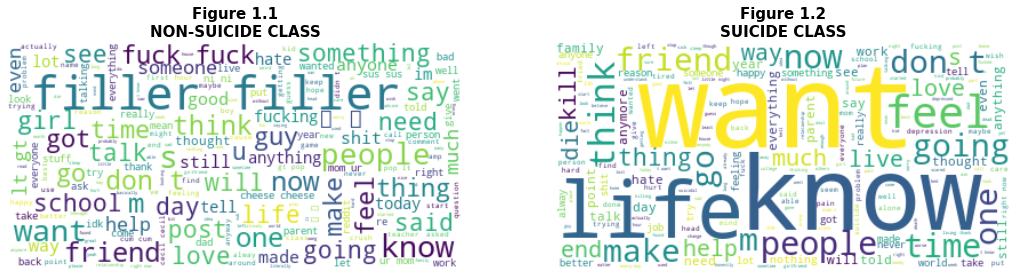

In [ ]:
fig = plt.figure(figsize=(18, 13))
  
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_ns, interpolation='bilinear')
plt.axis('off')
plt.title("Figure 1.1\nNON-SUICIDE CLASS", fontsize=15, weight='bold')
  
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_s, interpolation='bilinear')
plt.axis('off')
plt.title("Figure 1.2\nSUICIDE CLASS", fontsize=15, weight='bold')

The generated initial wordclouds above (figures 1.12 and 1.2) are still full of unnecessary words like *'filler'* and *'I'm'*. Hence, stop words are needed to be implemented to further clean the words to show only the necessary and relevant words. 

In [ ]:
sp = spacy.load('en_core_web_sm')

all_stopwords = sp.Defaults.stop_words
new_stopwords=["filler", " ", "S", "t", "s", "m", "█"]
comb_stopwords=list(new_stopwords)+list(all_stopwords)
wordcloud_ns = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_ns)
wordcloud_s = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_s)

C:\Users\Eleslie Gozon\anaconda3\lib\site-packages\spacy\util.py:865: UserWarning: [W095] Model 'en_core_web_sm' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


##### **Wordcloud**

To identify the most occurring words, a word cloud will be created for each class.

In [ ]:
text_ns = " ".join(i for i in ns.text).lower()
wordcloud_ns = WordCloud(background_color="white").generate(text_ns)

text_s = " ".join(i for i in s.text).lower()
wordcloud_s = WordCloud(background_color="white").generate(text_s)

In [ ]:
fig = plt.figure(figsize=(18, 13))
  
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_ns, interpolation='bilinear')
plt.axis('off')
plt.title("Figure 1.1\nNON-SUICIDE CLASS", fontsize=15, weight='bold')
  
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_s, interpolation='bilinear')
plt.axis('off')
plt.title("Figure 1.2\nSUICIDE CLASS", fontsize=15, weight='bold')

The generated initial wordclouds above (figures 1.12 and 1.2) are still full of unnecessary words like *'filler'* and *'I'm'*. Hence, stop words are needed to be implemented to further clean the words to show only the necessary and relevant words. 

In [ ]:
sp = spacy.load('en_core_web_sm')

all_stopwords = sp.Defaults.stop_words
new_stopwords=["filler", " ", "S", "t", "s", "m", "█"]
comb_stopwords=list(new_stopwords)+list(all_stopwords)
wordcloud_ns = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_ns)
wordcloud_s = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_s)

This is what the cleaned word cloud will look like.

Text(0.5, 1.0, 'Figure 2.2\nSUICIDE CLASS')

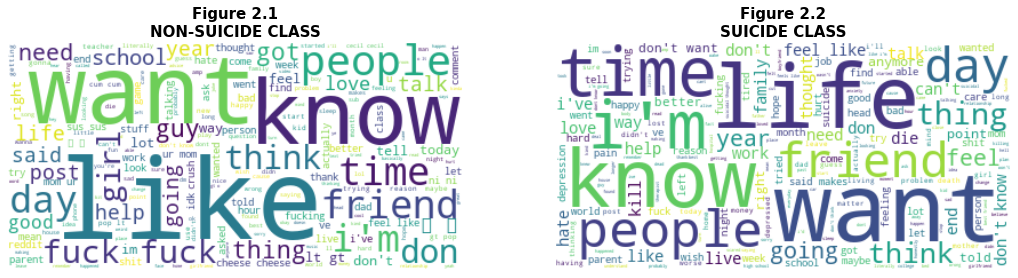

In [ ]:
fig = plt.figure(figsize=(18, 13))
  
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_ns, interpolation='bilinear')
plt.axis('off')
plt.title("Figure 2.1\nNON-SUICIDE CLASS", fontsize=15, weight='bold')
  
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_s, interpolation='bilinear')
plt.axis('off')
plt.title("Figure 2.2\nSUICIDE CLASS", fontsize=15, weight='bold')

Now the wordclouds are cleaner (refer to figures 2.1 and 2.2) showing the words '**like**', '**want**', and '**know**' to be the biggest words in the non-suicide class wordcloud signifying that these three words are the most occurring. However, for the suicide class, words: '**life**', '**want**', '**time**', '**i'm**', and '**know**' are the biggest words, meaning most occurring words.

To make the wordcloud more meaningful, another wordcloud is created but this time, **omitting the verbs and words containing verbs** (like the contraction I'm) as most of the identified occurring words are verbs, leaving only nouns as much as possible.

In [ ]:
all_stopwords = sp.Defaults.stop_words
new_stopwords_nv=["filler", " ", "S", "t", "s", "m", "█", "want", "like", "know", "help", "tell", "talk", "thought", "feel", "said", "going", "thinking", "I'm", "think", "fuck", "fucking", "look", "i've", "think", "don", "don't", "told", "feeling", "can't", "kill", "need", "tried", "try", "leave", "i'll", "having", "got", "went", "trying", "na", "im", "shit", "gt", "It", "▯"]
comb_stopwords=list(new_stopwords_nv)+list(all_stopwords)
wordcloud_ns_nv = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_ns)
wordcloud_s_nv = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_s)

Since there are no libraries for stop words that contain verbs, the verbs will be manually classified as stop words.

Text(0.5, 1.0, 'Figure 3.2\nSUICIDE CLASS (mostly noun)')

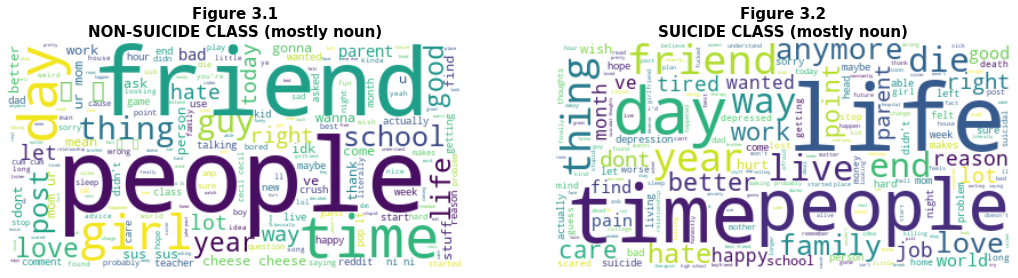

In [ ]:
fig = plt.figure(figsize=(18, 13))
  
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_ns_nv, interpolation='bilinear')
plt.axis('off')
plt.title("Figure 3.1\nNON-SUICIDE CLASS (mostly noun)", fontsize=15, weight='bold')
  
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_s_nv, interpolation='bilinear')
plt.axis('off')
plt.title("Figure 3.2\nSUICIDE CLASS (mostly noun)", fontsize=15, weight='bold')

For the mostly noun wordclouds (figures 3.1 and 3.2), the words **'people'**, **'friend'**, **'time'**, **'day'**, **'girl'**, and **'guy'** appear as the visibly large words in the non-suicide class. On the other hand, words **'life'**, **'time'**, **'people'**, **'friend'**, and **'day'** appear as the visibly large words. 

##### **Barplot**

To further process the results of the wordcloud, the next step is to quantify and visualize them using a barplot.

The first step is to combine all of the words into one string using the *.join* method and tokenize them.

In [ ]:
txt_ns = " ".join(ns['text'])
words_ns = word_tokenize(txt_ns)

txt_s = " ".join(s['text'])
words_s = word_tokenize(txt_s)

A function to clean the words named cleaned_words is created to convert all the strings into lowercase, remove all the stop words, and lemmatize each word to narrow down the terms. 

In [ ]:
def cleaned_words(new_tokens):
	new_tokens = [t.lower() for t in new_tokens]
	new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
	new_tokens =[t for t in new_tokens if t not in comb_stopwords] 
	new_tokens = [t for t in new_tokens if t.isalpha()]
	lemmatizer = WordNetLemmatizer()
	new_tokens = [lemmatizer.lemmatize(t) for t in new_tokens]
	return new_tokens

In [ ]:
lowered_ns = cleaned_words(words_ns)
lowered_s = cleaned_words(words_s)

Next the bag-of-words method is applied. *Bag-of-words* counts how many times each word appears, without considering grammar, word order, or meaning.

In [ ]:
bow_ns = Counter(lowered_ns)
bow_s = Counter(lowered_s)

Two dataframes are created to show word frequency for both of the classes: *data_ns* and *data_s*. The dataframe shows the most occurring words followed by the number of times it was used in descending order. Some of the rows had to be dropped like rows 2354, 35, 1125, 51, 13200, 62, 349, 1025, 1102, 4625, 1192, and 42 for the non-suicide class and row 6715 for the suicide class as these rows contain irrelevant words that weren't filtered out from the cleaned_words function.

In [ ]:
data_ns = pd.DataFrame(bow_ns.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
data_ns.drop([2354, 35, 1125, 51, 13200, 62, 349, 1025, 1102, 4625, 1192, 42], inplace = True)

data_s = pd.DataFrame(bow_s.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
data_s.drop([6715], inplace = True)

In [ ]:
data_ns.head(20)

,word,frequency
91,day,23263
57,people,23128
436,friend,22005
17,time,20252
574,school,15077
880,guy,14707
899,girl,14304
355,year,14263
129,good,13370
219,mom,11417


In [ ]:
data_s.head(20)

,word,frequency
92,life,123016
11,time,89402
54,people,77505
161,year,77383
241,friend,73409
111,thing,70447
19,day,60603
13,way,44027
631,anymore,42681
210,family,39051


After creating the dataframes, a barplot is created to visualize the contents of the datadrame. In the bar plot, the top 20 occuring words are shown. 

[Text(0.5, 1.0, 'Figure 4.1\nWord Frequency Count for NON-SUICIDE Class')]

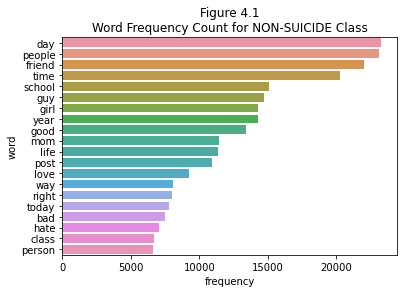

In [ ]:
data_ns = data_ns.head(20)
sns.barplot(x='frequency',y='word',data=data_ns).set(title='Figure 4.1\nWord Frequency Count for NON-SUICIDE Class')


In the non-suicide plot, the words day, people, friend, time, school, and guy appear as the most occurring words. Looking back at figure 3.1, the most occurring words identified were people, friend, time, day, girl, guy. This is only partly true for the barplot as the biggest word on figure 3.1 is either 'people' or 'friend'. However, figure 4.1 says otherwise by presenting that the most occurring word for the non-suicide class is actually **'day'**.


[Text(0.5, 1.0, 'Figure 4.2\nWord Frequency Count for SUICIDE Class')]

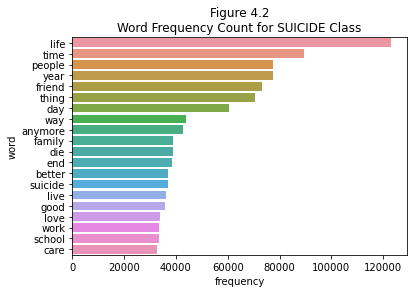

In [ ]:
data_s = data_s.head(20)
sns.barplot(x='frequency',y='word',data=data_s).set(title='Figure 4.2\nWord Frequency Count for SUICIDE Class')

Figure 4.2 shows the barplot for the suicide class. It shows that the words 'life', 'time', 'people', 'year', and 'friend' are the most occuring words determined. On figure 3.2, the identified top words are 'life', 'time', 'people', 'friend', and 'day', which is 80% similar to the findings on the barplot.

To conclude, it is not enough to rely on wordclouds to identify the most occurring words as stopwords can be subjective but wordclouds can better visualize the word frequency. On the other hand, barplot shows more reliable data as the number of words are actually shown in the figure, but it visualization can be a little outdated and highly technical, but easy to follow. 

The top 5 most occurring words for the *non-suicide class* are identified to be **day**, **people**, **friend**, **time**, and **school**, while the top 5 most occurring words for the *suicide class* is identified to be **life**, **time**, **people**, **year**, and **friend**.

#### **2. What is the length range of the statements per class?**

##### **Non-Suicide Class**

A copy of the class-separated non-suicide dataframe, *ns*, is created to keep the dataframes more flexible and useable.

In [ ]:
ns_2 = ns[['text']].copy(deep=True)
ns_2

,text
0,"'Its not a viable option, and youll be leaving..."
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ..."
...,...
232068,I did something today I went sledding with my ...
232069,If you don't like rock then your not going to ...
232070,You how you can tell i have so many friends an...
232071,pee probably tastes like salty tea😏💦‼️ can som...


The length of each statements and the length of range under the non-suicide class is taken by counting the number of spaces in the text column using *.str.count()* and adding 1 to account for the offset. As for the length of range, len() was used. Then, the length of each text (length) and the length of range (LoR) is placed in separate columns in the ns_2 dataframe.

In [ ]:
ns_2['length'] = ns_2['text'].str.count(' ') + 1
ns_2['LoR'] = ns_2['text'].str.len()
ns_2

,text,length,LoR
0,"'Its not a viable option, and youll be leaving...",133,719
5,"'Since I dont know what DBT is, would you mind...",2170,11212
6,"'No matter what you ever think, there will be ...",1101,5735
8,'The reason I have faith in our species abilit...,1873,10644
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ...",229,1249
...,...,...,...
232068,I did something today I went sledding with my ...,38,179
232069,If you don't like rock then your not going to ...,19,81
232070,You how you can tell i have so many friends an...,31,158
232071,pee probably tastes like salty tea😏💦‼️ can som...,14,87


The mean of the text length is then taken using *.mean()* to determine the average of *length* and *LoR* in the non-suicide dataframe. 

In [ ]:
ns_2["length"].mean()

60.27898998894991

In [ ]:
ns_2["LoR"].mean()

319.2023238170633

It is found that the **average length of statements** for the non-suicide class is approximately **61**, while the **average length of range** for each statements is found to be approximately **320**.

##### **Suicide Class**

A copy of the s dataframe, *s_2*, was created for this question.

In [ ]:
s_2 = s[['text']].copy(deep=True)
s_2

,text
1,'It can be hard to appreciate the notion that ...
2,"'Hi, so last night i was sitting on the ledge ..."
3,'I tried to kill my self once and failed badly...
4,'Hi NEM3030. What sorts of things do you enjoy...
7,"'Dont see it as failing at killing yourself, t..."
...,...
232061,I’ve fucking had enough.None of this depressio...
232062,paralyzing anxiety &amp; depression are pushin...
232066,My mom tried to kill herself today. I feel los...
232067,I’m a fucking scummy person and I can’t change...


The length of the sentences and the length of range of each text is determined using the same procedures done on the non-suicide class. To get the length, the spaces in between are counted. Then, an addition of 1 was placed to account for the first word. For the length of range (LoR), *.len()* is used to count all the characters within a specified range. For this case, the text per column is set as the range. 

In [ ]:
s_2['length'] = s_2['text'].str.count(' ') + 1
s_2['LoR'] = s_2['text'].str.len()
s_2

,text,length,LoR
1,'It can be hard to appreciate the notion that ...,2132,11495
2,"'Hi, so last night i was sitting on the ledge ...",470,2458
3,'I tried to kill my self once and failed badly...,891,4627
4,'Hi NEM3030. What sorts of things do you enjoy...,205,1112
7,"'Dont see it as failing at killing yourself, t...",1931,10031
...,...,...,...
232061,I’ve fucking had enough.None of this depressio...,82,424
232062,paralyzing anxiety &amp; depression are pushin...,1626,8751
232066,My mom tried to kill herself today. I feel los...,132,660
232067,I’m a fucking scummy person and I can’t change...,164,847


The mean of the text length is then taken using *.mean()* to determine the average of *length* and *LoR* in the suicide dataframe. 

In [ ]:
s_2["length"].mean()

204.31592138567672

In [ ]:
s_2["LoR"].mean()

1058.7299535129948

It is found that the average **length of statements** in the suicide class is averaging at **205** words, while the **length of range** for each statments has a mean value of **1059** characters.

When comparing the results of the average text length and length of range for each class. It is observed that **the average of the length and LoR in the suicide class are higher compared to the averages in the non-suicide class**. 

In [ ]:
text_s = " ".join(i for i in s.text).lower()
wordcloud_s = WordCloud(background_color="white").generate(text_s)

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow( wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
new_stopwords_s=["filler", " ", "S", "t", "s", "m"]
comb_stopwords_s=list(new_stopwords_s)+list(all_stopwords)
wordcloud_s = WordCloud(stopwords=comb_stopwords_s, background_color="white").generate(text)
print(new_stopwords_s)

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
txt_s = " ".join(s['text'])
words_s = word_tokenize(txt_s)

In [ ]:
def cleaned_words_s(new_tokens_s):
	new_tokens_s = [t.lower() for t in new_tokens_s]
	new_tokens_s =[t for t in new_tokens_s if t not in stopwords.words('english') and comb_stopwords_s]
	new_tokens_s = [t for t in new_tokens_s if t.isalpha()]
	lemmatizer = WordNetLemmatizer()
	new_tokens_s = [lemmatizer.lemmatize(t) for t in new_tokens_s]
	return new_tokens_s

In [ ]:
lowered_s = cleaned_words_s(words_s)

In [ ]:
bow_s = Counter(lowered_s)

In [ ]:
data_s = pd.DataFrame(bow_s.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
data_s = data_s.head(20)
sns.barplot(x='frequency',y='word',data=data_s)

#### **3. Are there statements that contain the word "suicide" but not under the suicide class?**

Another copy of the ns dataframe, *ns_3*, is created for this question.

In [ ]:
ns_3 = ns[['text']].copy(deep=True)
ns_3

,text
0,"'Its not a viable option, and youll be leaving..."
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ..."
...,...
232068,I did something today I went sledding with my ...
232069,If you don't like rock then your not going to ...
232070,You how you can tell i have so many friends an...
232071,pee probably tastes like salty tea😏💦‼️ can som...


The ns_3 dataframe is filtered such that it will only return all rows that contain the word **'suicide'**. This is done using *.contains()*.

In [ ]:
ns_filtered = ns_3[ns_3["text"].str.contains("suicide")]
ns_filtered

,text
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
49,'Have you considered that maybe she likes you ...
50,'U will get through this. Maybe scream instead...
...,...
230359,gentle reminder that if youre a guy that compl...
230778,"Recent Painful ""Graduation"" from the Subreddit..."
231056,"I wanna save my friend So,recently my friend s..."
231436,The story of my 2020 experience. This year was...


Another column is added to the dataframe, *frequency*, containing the the number of times the word **"suicide"** is mentioned per statement. 

In [ ]:
ns_filtered['frequency'] = ns_filtered['text'].str.count('suicide')
ns_filtered

C:\Users\ELESLI~1\AppData\Local\Temp/ipykernel_9720/1010264388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ns_filtered['frequency'] = ns_filtered['text'].str.count('suicide')


,text,frequency
5,"'Since I dont know what DBT is, would you mind...",2
6,"'No matter what you ever think, there will be ...",1
8,'The reason I have faith in our species abilit...,3
49,'Have you considered that maybe she likes you ...,8
50,'U will get through this. Maybe scream instead...,1
...,...,...
230359,gentle reminder that if youre a guy that compl...,1
230778,"Recent Painful ""Graduation"" from the Subreddit...",1
231056,"I wanna save my friend So,recently my friend s...",1
231436,The story of my 2020 experience. This year was...,3


To know the number of statements containing the word *'suicide'*, the shape of the dataframe has to be taken using *.shape*.

In [ ]:
ns_filtered.shape

(709, 2)

Results show that **there 709 statements containing the word suicide in the non-suicide class**.

#### **4. Are there non-suicide statements containing the top 3 most frequent words in the suicide texts?**

A third copy of the non-suicide dataframe, ns_4, is created for this question.

In [ ]:
ns_4 = ns[['text']].copy(deep=True)
ns_4

,text
0,"'Its not a viable option, and youll be leaving..."
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ..."
...,...
232068,I did something today I went sledding with my ...
232069,If you don't like rock then your not going to ...
232070,You how you can tell i have so many friends an...
232071,pee probably tastes like salty tea😏💦‼️ can som...


To recall the top 3 most frequent words in the suicide class, the barplot containing the word frequency in the suicide-class is shown.

[Text(0.5, 1.0, 'Figure 4.2\nWord Frequency Count for SUICIDE Class')]

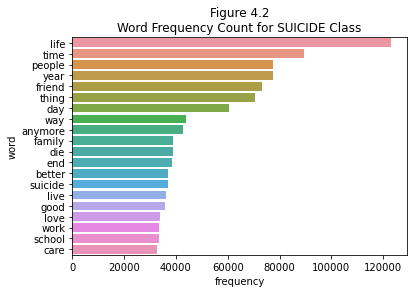

In [ ]:
data_s = data_s.head(20)
sns.barplot(x='frequency',y='word',data=data_s).set(title='Figure 4.2\nWord Frequency Count for SUICIDE Class')

Figure 4.2 shows that the top 3 most frequently mentioned words in the suicide class are '**life**', '**time**', and '**people**'. 

##### **Non-Suicide Statements Containing the Word 'life'**

A dataframe, *ns_life*, is created to show all of the statements in the non-suicide class that contains the word *'life'*.

In [ ]:
ns_life = ns_4[ns_4["text"].str.contains("life")]
ns_life

,text
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
20,'I hope you both can read this. Reading both o...
29,'Then maybe returningt there might be the firs...
...,...
231950,How 2020 ruined me Felt like reflecting on the...
232028,Got Friend zoned after talking to a girl for a...
232035,How in the fuck should I go about coming out t...
232045,"Bruh, imagine being Aaron Burr in the afterlif..."


To determine how many statements contain the word 'life', the shape of the dataframe is taken using .shape.

In [ ]:
ns_life.shape

(6929, 1)

Results show that **6,929 statements in the non-suicide class contain the word 'life'**.

##### **Non-Suicide Statements Containing the Word 'time'**

*ns_time* dataframe is a dataframe with all of the statements under the non-suicide class containing the word '*time*'. 

In [ ]:
ns_time = ns_4[ns_4["text"].str.contains("time")]
ns_time

,text
0,"'Its not a viable option, and youll be leaving..."
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ..."
...,...
232028,Got Friend zoned after talking to a girl for a...
232035,How in the fuck should I go about coming out t...
232036,Should I go back to my high school or should I...
232047,"My cat just died. My cat, Strawberry, just pas..."


*.shape* is used to know the number of statements or rows in the *ns_time* dataframe containing the word '*time*'.

In [ ]:
ns_time.shape

(15827, 1)

Results show that **there are 15,827 statements that contain the word 'time'**.

##### **Non-Suicide Statements Containing the Word 'people'**

A dataframe, *ns_people*, is created to show all of the statements in the non-suicide class containing the word '*people*'.

In [ ]:
ns_people = ns_4[ns_4["text"].str.contains("people")]
ns_people

,text
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ..."
20,'I hope you both can read this. Reading both o...
29,'Then maybe returningt there might be the firs...
...,...
232009,I don't know what triggered this huge influx o...
232019,I am going to get some peope their ass I feel ...
232021,Offering help I'm just putting this out there ...
232028,Got Friend zoned after talking to a girl for a...


In determining the number of rows or statements with the word '*people*', *.shape* is used.

In [ ]:
ns_people.shape

(14148, 1)

Results show that **there are 14,148 statements under the non-suicide class containing the word 'people'**.

In conclusion, **there are statements in the non-suicide class containing the top 3 most frequent words in the suicide class**: life, time, and people. There are 6,929 statements containing 'life', 15,827 statements containing 'time', and 14,148 statements containing the word 'people'.

#### **5. What are the sentiment score of the statements per class?**

A copy of the non-suicide (ns) and suicide (s) class dataframes were created for this section under the names ns_SA and s_SA, respectively.

In [ ]:
ns_SA = ns.copy(deep=True)
s_SA = s.copy(deep=True)

##### **Non-Suicide Class**

Initially, the text column in the dataframe is fixed by converting all characters to lowercase using *.lower()*. Then, it undergoes tokenization using **RegexpTokenizer** so the sentiment analysis can occur at a token level.

In [ ]:
ns_SA['text'] = ns_SA['text'].astype(str).str.lower()
regexp = RegexpTokenizer('\w+')

In [ ]:
ns_SA['text_token']=ns_SA['text'].apply(regexp.tokenize)

Another column is added to the dataframe as tokenized statements are joined into a text string, but Stopwords are used beforehand to remove unnecessary words and improve processing speed.

In [ ]:
stopwords = nltk.corpus.stopwords.words("english")

In [ ]:
my_stopwords = ['https']
stopwords.extend(my_stopwords)

In [ ]:
ns_SA['text_token'] = ns_SA['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
ns_SA['text_string'] = ns_SA['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [ ]:
ns_SA[['text', 'text_token', 'text_string']]

,text,text_token,text_string
0,"'its not a viable option, and youll be leaving...","[viable, option, youll, leaving, wife, behind,...",viable option youll leaving wife behind youd p...
5,"'since i dont know what dbt is, would you mind...","[since, dont, know, dbt, would, mind, explaini...",since dont know dbt would mind explaining litt...
6,"'no matter what you ever think, there will be ...","[matter, ever, think, people, care, whether, p...",matter ever think people care whether people l...
8,'the reason i have faith in our species abilit...,"[reason, faith, species, ability, spread, surv...",reason faith species ability spread survive ho...
11,"'whats up? tell me. im here for you. ', 'wow. ...","[whats, tell, im, wow, cant, imagine, heavy, m...",whats tell wow cant imagine heavy must cancer ...
...,...,...,...
232068,i did something today i went sledding with my ...,"[something, today, went, sledding, friends, ma...",something today went sledding friends may seem...
232069,if you don't like rock then your not going to ...,"[like, rock, going, get, anything, go]",like rock going get anything
232070,you how you can tell i have so many friends an...,"[tell, many, friends, lonely, everything, depr...",tell many friends lonely everything deprived p...
232071,pee probably tastes like salty tea😏💦‼️ can som...,"[pee, probably, tastes, like, salty, tea, some...",pee probably tastes like salty tea someone dra...


The tokenized text will be re-tokenized using the *nltk tokenize package*, this time according to space and punctuation. Furthermore, *FreqDist* is applied to determine the frequency of each words in a statement. After that, lemmatization is applied  using *WordNetLemmatizer()* so that words of the same base will count as one.

In [ ]:
all_words = ' '.join([word for word in ns_SA['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)

fdist = FreqDist(tokenized_words)

ns_SA['text_string_fdist'] = ns_SA['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
ns_SA[['text', 'text_token', 'text_string', 'text_string_fdist']].tail()

,text,text_token,text_string,text_string_fdist
232068,i did something today i went sledding with my ...,"[something, today, went, sledding, friends, ma...",something today went sledding friends may seem...,something today went sledding friends may seem...
232069,if you don't like rock then your not going to ...,"[like, rock, going, get, anything, go]",like rock going get anything,like rock going get anything
232070,you how you can tell i have so many friends an...,"[tell, many, friends, lonely, everything, depr...",tell many friends lonely everything deprived p...,tell many friends lonely everything deprived p...
232071,pee probably tastes like salty tea😏💦‼️ can som...,"[pee, probably, tastes, like, salty, tea, some...",pee probably tastes like salty tea someone dra...,pee probably tastes like salty tea someone dra...
232073,i still haven't beaten the first boss in hollo...,"[still, beaten, first, boss, hollow, knight, f...",still beaten first boss hollow knight fought t...,still beaten first boss hollow knight fought t...


In [ ]:
wordnet_lem = WordNetLemmatizer()

ns_SA['text_string_lem'] = ns_SA['text_string_fdist'].apply(wordnet_lem.lemmatize)

# check if the columns are equal
ns_SA['is_equal']= (ns_SA['text_string_fdist']==ns_SA['text_string_lem'])
# show level count
ns_SA.is_equal.value_counts()

True     121251
False        15
Name: is_equal, dtype: int64

**Sentiment analysis** is done on the lemmatized text string, where the *negative*, *neutral*, *positive*, and *compound* scores are created into columns. **The compound score serves as the overall score of the statement**.

In [ ]:
analyzer = SentimentIntensityAnalyzer()

ns_SA['polarity'] = ns_SA['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))

# Change data structure
ns_SA = pd.concat(
     [ns_SA.drop(['polarity'], axis=1), 
     ns_SA['polarity'].apply(pd.Series)], axis=1)

The sentiment of each statement is classified according to their compound score. 

In [ ]:
def condition(x):
    if x>0:
        return "positive"
    elif x==0:
        return "neutral"
    else:
        return 'negative'

ns_SA['sentiment'] = ns_SA['compound'].apply(condition)

ns_SA.tail()

,class,text,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment
232068,0,i did something today i went sledding with my ...,"[something, today, went, sledding, friends, ma...",something today went sledding friends may seem...,something today went sledding friends may seem...,something today went sledding friends may seem...,True,0.000,0.457,0.543,0.8979,positive
232069,0,if you don't like rock then your not going to ...,"[like, rock, going, get, anything, go]",like rock going get anything,like rock going get anything,like rock going get anything,True,0.000,0.615,0.385,0.3612,positive
232070,0,you how you can tell i have so many friends an...,"[tell, many, friends, lonely, everything, depr...",tell many friends lonely everything deprived p...,tell many friends lonely everything deprived p...,tell many friends lonely everything deprived p...,True,0.284,0.558,0.157,-0.3612,negative
232071,0,pee probably tastes like salty tea😏💦‼️ can som...,"[pee, probably, tastes, like, salty, tea, some...",pee probably tastes like salty tea someone dra...,pee probably tastes like salty tea someone dra...,pee probably tastes like salty tea someone dra...,True,0.000,0.783,0.217,0.3612,positive
232073,0,i still haven't beaten the first boss in hollo...,"[still, beaten, first, boss, hollow, knight, f...",still beaten first boss hollow knight fought t...,still beaten first boss hollow knight fought t...,still beaten first boss hollow knight fought t...,True,0.604,0.396,0.000,-0.9354,negative


The total number of the positive, negative, and neutral statements are explored using *.value_counts()*. It shows that **most of the statements in the non-suicide class are classified to have a positive sentiment**. A bar plot is created to visualize the count.

In [ ]:
ns_SA['sentiment'].value_counts()

positive    63899
negative    43698
neutral     13669
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Non-Suicide Class Sentiment Text Values by Counts')

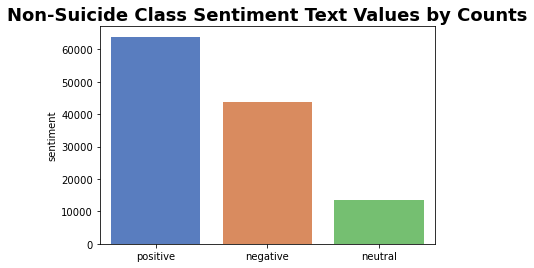

In [ ]:
sns.set_palette('muted')
ax = sns.barplot(x=ns_SA['sentiment'].value_counts().index, y=ns_SA['sentiment'].value_counts())
ax.set_title('Non-Suicide Class Sentiment Text Values by Counts', fontsize=18, fontweight='bold')

##### **Suicide Class**

The dataframe's text column is initially adjusted by using the *.lower()* function to lowercase all characters. Then, it is tokenized using *RegexpTokenizer* so that token-level sentiment analysis may take place.

In [ ]:
s_SA['text'] = s_SA['text'].astype(str).str.lower()
regexp = RegexpTokenizer('\w+')

In [ ]:
s_SA['text_token']=s_SA['text'].apply(regexp.tokenize)

The statements will be tokenized and then rejoined into a text string. To reduce the number of words that need to be processed, Stopwords are applied prior to joining it. hence, faster results.

In [ ]:
s_SA['text_token'] = s_SA['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
s_SA['text_string'] = s_SA['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [ ]:
s_SA[['text', 'text_token', 'text_string']]

,text,text_token,text_string
1,'it can be hard to appreciate the notion that ...,"[hard, appreciate, notion, could, meet, someon...",hard appreciate notion could meet someone else...
2,"'hi, so last night i was sitting on the ledge ...","[hi, last, night, sitting, ledge, window, cont...",last night sitting ledge window contemplating ...
3,'i tried to kill my self once and failed badly...,"[tried, kill, self, failed, badly, cause, mome...",tried kill self failed badly cause moment want...
4,'hi nem3030. what sorts of things do you enjoy...,"[hi, nem3030, sorts, things, enjoy, personally...",nem3030 sorts things enjoy personally always w...
7,"'dont see it as failing at killing yourself, t...","[dont, see, failing, killing, theres, reason, ...",dont see failing killing theres reason lived t...
...,...,...,...
232061,i’ve fucking had enough.none of this depressio...,"[fucking, enough, none, depression, subs, help...",fucking enough none depression subs helped ugl...
232062,paralyzing anxiety &amp; depression are pushin...,"[paralyzing, anxiety, amp, depression, pushing...",paralyzing anxiety amp depression pushing edge...
232066,my mom tried to kill herself today. i feel los...,"[mom, tried, kill, today, feel, lost, second, ...",mom tried kill today feel lost second time hap...
232067,i’m a fucking scummy person and i can’t change...,"[fucking, scummy, person, change, itever, sinc...",fucking scummy person change itever since kid ...


Using the *nltk tokenize package*, the tokenized text will be re-tokenized, this time taking space and punctuation into account. Additionally, the application of *FreqDist* is used to ascertain the frequency of each word in a sentence. Following that, words with the same base are lemmatized using *WordNetLemmatizer()* so that they only count as one.

In [ ]:
all_words = ' '.join([word for word in s_SA['text_string']])

In [ ]:
s_SA['text_string_fdist'] = s_SA['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
s_SA[['text', 'text_token', 'text_string', 'text_string_fdist']].tail()

,text,text_token,text_string,text_string_fdist
232061,i’ve fucking had enough.none of this depressio...,"[fucking, enough, none, depression, subs, help...",fucking enough none depression subs helped ugl...,fucking enough none depression subs helped ugl...
232062,paralyzing anxiety &amp; depression are pushin...,"[paralyzing, anxiety, amp, depression, pushing...",paralyzing anxiety amp depression pushing edge...,paralyzing anxiety amp depression pushing edge...
232066,my mom tried to kill herself today. i feel los...,"[mom, tried, kill, today, feel, lost, second, ...",mom tried kill today feel lost second time hap...,mom tried kill today feel lost second time hap...
232067,i’m a fucking scummy person and i can’t change...,"[fucking, scummy, person, change, itever, sinc...",fucking scummy person change itever since kid ...,fucking scummy person change since kid get tro...
232072,the usual stuff you find herei'm not posting t...,"[usual, stuff, find, herei, posting, sympathy,...",usual stuff find herei posting sympathy pity k...,usual stuff find posting sympathy pity know fa...


In [ ]:
s_SA['text_string_lem'] = s_SA['text_string_fdist'].apply(wordnet_lem.lemmatize)

In [ ]:
# check if the columns are equal
s_SA['is_equal']= (s_SA['text_string_fdist']==s_SA['text_string_lem'])
# show level count
s_SA.is_equal.value_counts()

True     120884
False        10
Name: is_equal, dtype: int64

The lemmatized text string is subjected to **sentiment analysis**, and columns are generated for the *negative*, *neutral*, *positive*, and *compound* scores. The statement is given an overall score based on its compound score.

In [ ]:
s_SA['polarity'] = s_SA['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))

# Change data structure
s_SA = pd.concat(
     [s_SA.drop(['polarity'], axis=1), 
     s_SA['polarity'].apply(pd.Series)], axis=1)

According to their compound score, each statement's sentiment is categorized. 

In [ ]:
s_SA['sentiment'] = s_SA['compound'].apply(condition)

s_SA.tail()

,class,text,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment
232061,1,i’ve fucking had enough.none of this depressio...,"[fucking, enough, none, depression, subs, help...",fucking enough none depression subs helped ugl...,fucking enough none depression subs helped ugl...,fucking enough none depression subs helped ugl...,True,0.468,0.475,0.057,-0.9696,negative
232062,1,paralyzing anxiety &amp; depression are pushin...,"[paralyzing, anxiety, amp, depression, pushing...",paralyzing anxiety amp depression pushing edge...,paralyzing anxiety amp depression pushing edge...,paralyzing anxiety amp depression pushing edge...,True,0.249,0.591,0.160,-0.9982,negative
232066,1,my mom tried to kill herself today. i feel los...,"[mom, tried, kill, today, feel, lost, second, ...",mom tried kill today feel lost second time hap...,mom tried kill today feel lost second time hap...,mom tried kill today feel lost second time hap...,True,0.326,0.481,0.194,-0.9169,negative
232067,1,i’m a fucking scummy person and i can’t change...,"[fucking, scummy, person, change, itever, sinc...",fucking scummy person change itever since kid ...,fucking scummy person change since kid get tro...,fucking scummy person change since kid get tro...,True,0.398,0.525,0.078,-0.9823,negative
232072,1,the usual stuff you find herei'm not posting t...,"[usual, stuff, find, herei, posting, sympathy,...",usual stuff find herei posting sympathy pity k...,usual stuff find posting sympathy pity know fa...,usual stuff find posting sympathy pity know fa...,True,0.288,0.514,0.198,-0.9679,negative


Using *.value_counts()*, the total number of the positive negative, and neutral statements is examined. It shows that **the majority of the suicide statements are categorized as having negative sentiment**. The count is represented visually via a barplot.

In [ ]:
s_SA['sentiment'].value_counts()

negative    83398
positive    35625
neutral      1871
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Suicide Class Sentiment Text Values by Counts')

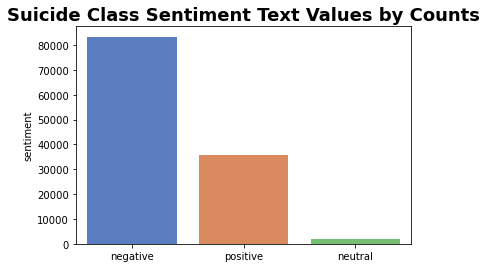

In [ ]:
sns.set_palette('muted')
ax = sns.barplot(x=s_SA['sentiment'].value_counts().index, y=s_SA['sentiment'].value_counts())
ax.set_title('Suicide Class Sentiment Text Values by Counts', fontsize=18, fontweight='bold')

## **Conclusion**

## References